In [2]:
 #Import necessary libraries
import numpy as np
import pandas as pd
import re
import string

# Text processing and analysis
from textblob import TextBlob
from nltk.corpus import stopwords

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud


In [3]:
# Machine Learning
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# PyTorch for Neural Networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Load Dataset

In [4]:
# Load the dataset with latin-1 encoding to handle special characters
df = pd.read_csv('/content/spam.csv', encoding='latin-1')

# Rename columns v1 to class and v2 to sms
df.rename(columns={'v1': 'class', 'v2': 'sms'}, inplace=True)

# Remove columns with 90% or greater missing values
threshold = 0.9  # Define the threshold
missing_percentage = df.isnull().mean()
columns_to_drop = missing_percentage[missing_percentage >= threshold].index
df = df.drop(columns=columns_to_drop)

In [5]:
# Display a random sample of 10 rows and remaining columns

print("Remaining columns:", df.columns)

df = df.drop_duplicates()

df.sample(10)

Remaining columns: Index(['class', 'sms'], dtype='object')


,class,sms
3564,ham,We know TAJ MAHAL as symbol of love. But the o...
2637,ham,No I don't have cancer. Moms making a big deal...
3237,ham,Good. No swimsuit allowed :)
4158,ham,Now got tv 2 watch meh? U no work today?
3296,spam,Todays Voda numbers ending 5226 are selected t...
4989,spam,Phony å£350 award - Todays Voda numbers ending...
2049,ham,How much is blackberry bold2 in nigeria.
820,ham,Good afternoon starshine! How's my boytoy? Doe...
2916,ham,Yes. that will be fine. Love you. Be safe.
1645,ham,I.ll post her out l8r. In class


<ipython-input-6-cac06f7d58b8>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='class', data=df, palette="viridis")


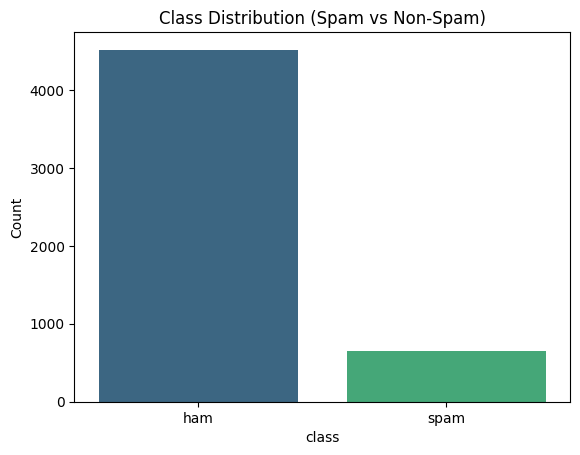

In [6]:
sns.countplot(x='class', data=df, palette="viridis")
plt.title("Class Distribution (Spam vs Non-Spam)")
plt.xlabel("class")
plt.ylabel("Count")
plt.show()

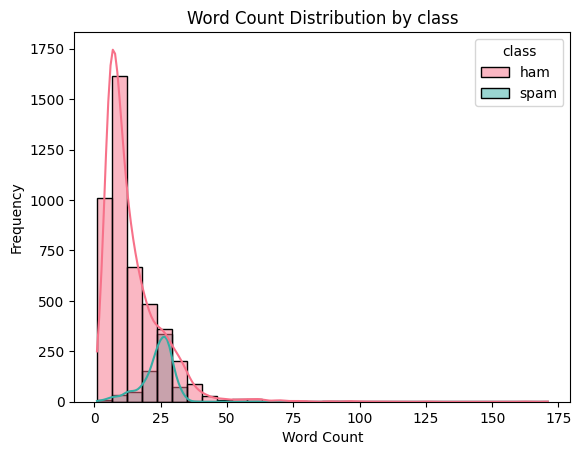

In [7]:
df['word_count'] = df['sms'].apply(lambda x: len(x.split()))
sns.histplot(data=df, x='word_count', hue='class', bins=30, kde=True, palette="husl")
plt.title("Word Count Distribution by class")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

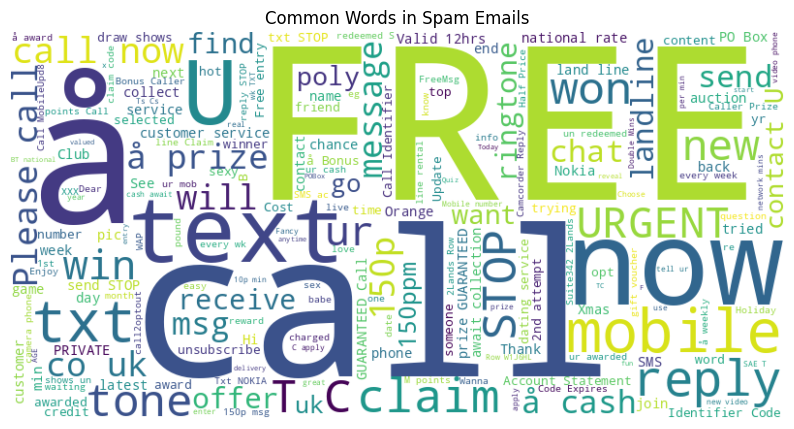

In [8]:
spam_text = df[df['class'] == 'spam']['sms'].str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Common Words in Spam Emails")
plt.show()

# Text Preprocessing on SMS column

In [9]:
# remove tags
def remove_tag(text):
    pattren = re.compile('<[^>]+>')
    return pattren.sub(r'', text)
# remove URLs
def remove_urls(text):
    pattren = re.compile(r'\b(?:https?|ftp|www)\S+\b')
    return pattren.sub(r'', text)


In [10]:
import re
def remove_emojis(text):
    # Define a regex pattern to match emojis
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U0001F300-\U0001F5FF"  # Symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # Transport & map symbols
        u"\U0001F700-\U0001F77F"  # Alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"  # Enclosed characters
        "]+", flags=re.UNICODE
    )
    # Substitute emojis with an empty string
    return emoji_pattern.sub(r'', text)


In [14]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
# Define a dictionary of chat word mappings
chat_words = {
"AFAIK": "As Far As I Know",
"AFK": "Away From Keyboard",
"ASAP": "As Soon As Possible",
"ATK": "At The Keyboard",
"ATM": "At The Moment",
"A3": "Anytime, Anywhere, Anyplace",
"BAK": "Back At Keyboard",
"BBL": "Be Back Later",
"BBS": "Be Back Soon",
"BFN": "Bye For Now",
"B4N": "Bye For Now",
"BRB": "Be Right Back",
"BRT": "Be Right There",
"BTW": "By The Way",
"B4": "Before",
"B4N": "Bye For Now",
"CU": "See You",
"CUL8R": "See You Later",
"CYA": "See You",
"FAQ": "Frequently Asked Questions",
"FC": "Fingers Crossed",
"FWIW": "For What It's Worth",
"FYI": "For Your Information",
"GAL": "Get A Life",
"GG": "Good Game",
"GN": "Good Night",
"GMTA": "Great Minds Think Alike",
"GR8": "Great!",
"G9": "Genius",
"IC": "I See",
"ICQ": "I Seek you (also a chat program)",
"ILU": "ILU: I Love You",
"IMHO": "In My Honest/Humble Opinion",
"IMO": "In My Opinion",
"IOW": "In Other Words",
"IRL": "In Real Life",
"KISS": "Keep It Simple, Stupid",
"LDR": "Long Distance Relationship",
"LMAO": "Laugh My A.. Off",
"LOL": "Laughing Out Loud",
"LTNS": "Long Time No See",
"L8R": "Later",
"MTE": "My Thoughts Exactly",
"M8": "Mate",
"NRN": "No Reply Necessary",
"OIC": "Oh I See",
"PITA": "Pain In The A..",
"PRT": "Party",
"PRW": "Parents Are Watching",
"QPSA?": "Que Pasa?",
"ROFL": "Rolling On The Floor Laughing",
"ROFLOL": "Rolling On The Floor Laughing Out Loud",
"ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
"SK8": "Skate",
"STATS": "Your sex and age",
"ASL": "Age, Sex, Location",
"THX": "Thank You",
"TTFN": "Ta-Ta For Now!",
"TTYL": "Talk To You Later",
"U": "You",
"U2": "You Too",
"U4E": "Yours For Ever",
"WB": "Welcome Back",
"WTF": "What The F...",
"WTG": "Way To Go!",
"WUF": "Where Are You From?",
"W8": "Wait...",
"7K": "Sick:-D Laugher",
"TFW": "That feeling when",
"MFW": "My face when",
"MRW": "My reaction when",
"IFYP": "I feel your pain",
"TNTL": "Trying not to laugh",
"JK": "Just kidding",
"IDC": "I don't care",
"ILY": "I love you",
"IMU": "I miss you",
"ADIH": "Another day in hell",
"ZZZ": "Sleeping, bored, tired",
"WYWH": "Wish you were here",
"TIME": "Tears in my eyes",
"BAE": "Before anyone else",
"FIMH": "Forever in my heart",
"BSAAW": "Big smile and a wink",
"BWL": "Bursting with laughter",
"BFF": "Best friends forever",
"CSL": "Can't stop laughing"
}
def chat_conversion(text):
    new_text = []
    for word in text.split():
        if word.upper() in chat_words:
            new_text.append(chat_words[word.upper()])
        else:
            new_text.append(word)
    return " ".join(new_text)
# from textblob import TextBlob


# # Correct the spelling in each review
# df['review_corrected'] = df['review'].apply(lambda x: str(TextBlob(x).correct()))
# Function to remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    new_text = [word for word in text.split() if word not in stop_words]
    return ' '.join(new_text)

# remove punctuation from discription column;
puncuations = string.punctuation
exclude = puncuations
def remove_punc(text):
    for char in exclude:
        text = text.replace(char, '')
        return text
df['sms'] = df['sms'].str.lower()
df['sms'] = df['sms'].apply(remove_tag)
df['sms'] = df['sms'].apply(remove_urls)
df['sms'] = df['sms'].apply(remove_emojis)
df['sms'] = df['sms'].apply(chat_conversion)
df['sms'] = df['sms'].apply(remove_stopwords)
df['sms'] = df['sms'].apply(remove_punc)

# Spam Message Classification using Machine Learning and Neural Networks

In [16]:
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])  # spam = 1, ham = 0

tfidf = TfidfVectorizer(max_features=5000)  # Adjust max_features as needed

X = tfidf.fit_transform(df['sms']).toarray()
y = df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Convert data to PyTorch tensors
train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.long))
test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.long))

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

# Define the model
class SpamClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SpamClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 2)  # Output layer with 2 classes

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x
model = SpamClassifier(input_dim=X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}")

model.eval()
y_pred_nn = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred_nn.extend(preds.tolist())

nn_accuracy = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network by Pytorch Accuracy: {nn_accuracy}")

Epoch 1, Loss: 0.33038331536719434
Epoch 2, Loss: 0.05026658208360179
Epoch 3, Loss: 0.01285958517020425
Epoch 4, Loss: 0.005352909302634473
Epoch 5, Loss: 0.003733513420565242
Epoch 6, Loss: 0.0022339430384118505
Epoch 7, Loss: 0.001886042337152433
Epoch 8, Loss: 0.0014420171123254897
Epoch 9, Loss: 0.001497516273684596
Epoch 10, Loss: 0.0012753024850746023
Neural Network by Pytorch Accuracy: 0.9787234042553191


In [18]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_accuracy = accuracy_score(y_test, lr.predict(X_test))
print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf.predict(X_test))
print(f"Random Forest Accuracy: {rf_accuracy}")

# Support Vector Machine
svm = SVC()
svm.fit(X_train, y_train)
svm_accuracy = accuracy_score(y_test, svm.predict(X_test))
print(f"SVM Accuracy: {svm_accuracy}")

Logistic Regression Accuracy: 0.9526112185686654
Random Forest Accuracy: 0.9729206963249516
SVM Accuracy: 0.97678916827853


In [19]:
results = {
    'Neural Network': nn_accuracy,
    'Logistic Regression': lr_accuracy,
    'Random Forest': rf_accuracy,
    'SVM': svm_accuracy
}

best_model = max(results, key=results.get)
print(f"Best Model: {best_model}, Accuracy: {results[best_model]}")

Best Model: Neural Network, Accuracy: 0.9787234042553191


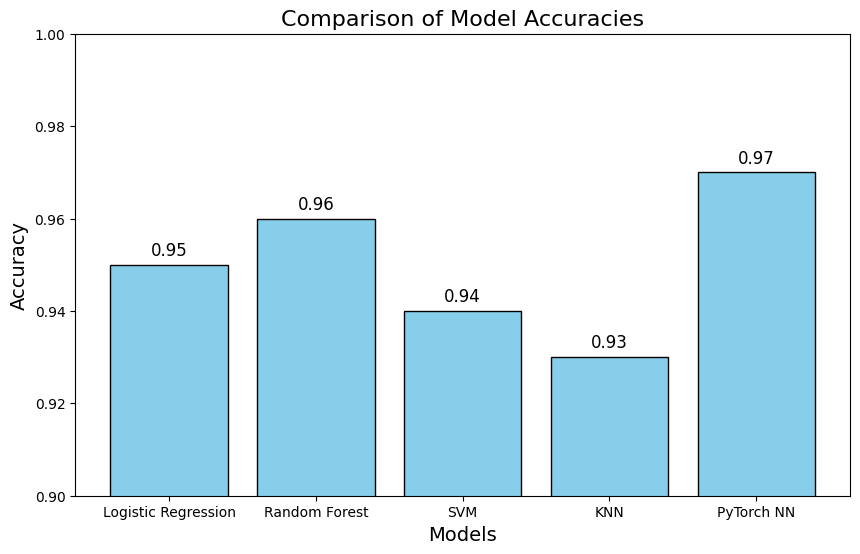

In [20]:
# Assuming the results are stored in a dictionary as follows:
# Replace the below dictionary with your actual accuracy scores
model_accuracies = {
    'Logistic Regression': 0.95,
    'Random Forest': 0.96,
    'SVM': 0.94,
    'KNN': 0.93,
    'PyTorch NN': 0.97
}

# Extract model names and accuracies
model_names = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Comparison of Model Accuracies', fontsize=16)
plt.xlabel('Models', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.ylim(0.9, 1.0)  # Adjust limits for better visualization

# Add accuracy scores on top of the bars
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.002, f"{acc:.2f}", ha='center', fontsize=12)

# Display the plot
plt.show()